#  Unitarity Avoids Overfitting

This example is to show the power of overfit-proof of QNN.

Classical method is the Lagrange interpolation of $f(x)=\frac{1}{1+x^2}$ with $12$ equal spaced nodes.

Plot the resultant polynomial with $24$ equal spaced nodes.

In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import warnings
warnings.filterwarnings("ignore")

In [2]:
import paddle
import numpy as np
import paddle_quantum
from paddle_quantum.ansatz import Circuit
from paddle_quantum.hamiltonian import Hamiltonian
from paddle_quantum.loss import ExpecVal
import matplotlib.pyplot as plt
import matplotlib

paddle_quantum.set_backend("state_vector")

C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\urllib3\util\selectors.py:14: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import namedtuple, Mapping
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\urllib3\_collections.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\openfermion\hamiltonians\hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\tensor\creatio

Use the same QNN network from single qubit QNN

In [3]:
def U_WZW(train_block, w_theta, x):
    cir = Circuit(1)
    #Add part of the circuit equivlant to the summation part 
    for i in range(train_block):
        cir.rz(0, param=w_theta[i][1])
        cir.ry(0, param=w_theta[i][0])
        cir.rz(0, param=x) 
    #Add the first Ry,Rz
    cir.rz(0, param=w_theta[-1][1])
    cir.ry(0, param=w_theta[-1][0])
    return cir

In [4]:
class QNN(paddle.nn.Layer):
    def __init__(self, 
                 train_block,          
                 SEED=0,
                 dtype='float64'):
        super(QNN, self).__init__()
        self.train_block = train_block
        paddle.seed(SEED)
        self.coeff  = self.create_parameter(
            shape=[1],
            default_initializer=paddle.nn.initializer.Normal(std=0.01),
            dtype='float64',
            is_bias=False)
        self.w_theta = self.create_parameter(
            shape=[(train_block+1), 2],
            default_initializer=paddle.nn.initializer.Uniform(0.0, 2*np.pi),
            dtype=dtype,
            is_bias=False)


    def forward(self, x):
        predict = []
        H = Hamiltonian([(1.0, "z0")])
        out_func = ExpecVal(H)
        x = paddle.to_tensor(x, dtype='float64')
        if len(x.shape) == 1:  
            x = x.reshape((-1, 1))
        for i in range(x.shape[0]):
            cir = U_WZW(self.train_block, self.w_theta, x[i])
            out_state = cir()
            out_val = out_func(out_state) 
            predict.append(out_val)
        
        return paddle.concat(predict).reshape((-1,)), cir

In [5]:
def train_qnn(x, y, train_block, LR , Epoch,SEED, BATCHSIZE):
    model = QNN(train_block, SEED)
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=model.parameters())
    loss_list = []
    x = paddle.to_tensor(x, dtype='float64')
    y = paddle.to_tensor(y, dtype='float64')
    for ep in range(1, Epoch + 1):
        
        for itr in range(len(x) // BATCHSIZE):
            l = itr*BATCHSIZE
            r = min( (itr + 1) * BATCHSIZE , len(x) )
            x_batch = x[l:r]
            y_batch = y[l:r]
            predict, cir = model(x_batch)
            avg_loss = paddle.mean((predict - y_batch) ** 2)
            loss_list.append(avg_loss.numpy())
            avg_loss.backward()
            opt.minimize(avg_loss)
            opt.clear_grad()
        print("qnn:epoch:", ep, " train  loss:", "%.5f" % avg_loss.numpy())
        


    return model, loss_list

Create data points with $12$ equal spaced nodes over $[-5,5]$

In [6]:
def target_func(x):
    return 1/(x**2+1) 


def get_data():

    x_all = np.arange(-5, 5, 10/12)

    y_all = target_func(x_all)
    
    return x_all,y_all

x_train, y_train = get_data()

In [7]:
SEED = 2
Epoch = 10
LR = 0.05
train_block = 3
bs = 1
model, loss_list = train_qnn(x_train, y_train, train_block=train_block, LR=LR, Epoch=Epoch, SEED=SEED,BATCHSIZE=bs)

C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\fluid\framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:


qnn:epoch: 1  train  loss: 0.24679
qnn:epoch: 2  train  loss: 0.12251
qnn:epoch: 3  train  loss: 0.04997
qnn:epoch: 4  train  loss: 0.00959
qnn:epoch: 5  train  loss: 0.00041
qnn:epoch: 6  train  loss: 0.00023
qnn:epoch: 7  train  loss: 0.00070
qnn:epoch: 8  train  loss: 0.00073
qnn:epoch: 9  train  loss: 0.00077
qnn:epoch: 10  train  loss: 0.00074


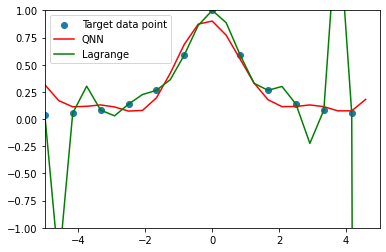

In [8]:
plt.scatter(x_train, y_train, label="Target data point")

testrange = np.arange(-5,5,10/24)
predict = model(testrange)

plt.plot(testrange,predict[0].numpy(),color="r",label="QNN",)

from scipy.interpolate import lagrange
f = lagrange(x_train,y_train)

plt.plot(testrange, f(testrange),color='g',label='Lagrange')


plt.xlim(-5, 5)
plt.ylim(-1, 1)
plt.legend()
plt.show()

We can see that the Lagrange interpolation overfits, Runge's phenomenon appears.

However, QNN does not overfit.